In [124]:
import pandas
import numpy 
import sklearn 
import csv
import matplotlib
import matplotlib.pyplot as pyplot
import matplotlib.ticker as ticker

DRAFT_DATA_PATH = './data/draft_data_public.MKM.PremierDraft.csv'

NUM_IN_PACK = 13
NUM_PACKS = 3

MIN_SAMPLE_SIZE = 2500

In [23]:
with open(PATH) as csvfile:
    draft_data = csv.reader(csvfile)
    columns = next(draft_data)
        

NAMES = [col.split('pack_card_')[1] for col in columns if 'pack_card_' in col]
PICK_IDX = columns.index('pick')
DRAFTID_IDX = columns.index('draft_id')
DRAFTTIME_IDX = columns.index('draft_time')
PACKNUM_IDX = columns.index('pack_number')
PICKNUM_IDX = columns.index('pick_number')
MATCHWINS_IDX = columns.index('event_match_wins')
MATCHLOSSES_IDX = columns.index('event_match_losses')

PACK_IDX = columns.index('pack_card_A Killer Among Us')
POOL_IDX = columns.index('pool_A Killer Among Us')
NUM_CARDS = len(NAMES)

def card_vector(index, row):
    return numpy.array([int(x) for x in row[index:index + NUM_CARDS]])

In [115]:
match_wins_early = numpy.zeros((NUM_CARDS, NUM_IN_PACK), dtype=numpy.intc)
match_losses_early = numpy.zeros((NUM_CARDS, NUM_IN_PACK), dtype=numpy.intc)

match_wins = numpy.zeros((NUM_CARDS, NUM_IN_PACK), dtype=numpy.intc)
match_losses = numpy.zeros((NUM_CARDS, NUM_IN_PACK), dtype=numpy.intc)

with open(PATH) as csvfile:
    draft_data = csv.reader(csvfile)
    columns = next(draft_data)
    
    for row in draft_data:
        if row[DRAFTTIME_IDX] < '2024-02-20':
            match_wins_early[NAMES.index(row[PICK_IDX]), int(row[PICKNUM_IDX])] += int(row[MATCHWINS_IDX])
            match_losses_early[NAMES.index(row[PICK_IDX]), int(row[PICKNUM_IDX])] += int(row[MATCHLOSSES_IDX])
    
        match_wins[NAMES.index(row[PICK_IDX]), int(row[PICKNUM_IDX])] += int(row[MATCHWINS_IDX])
        match_losses[NAMES.index(row[PICK_IDX]), int(row[PICKNUM_IDX])] += int(row[MATCHLOSSES_IDX])
    
        

In [197]:
match_counts = match_wins + match_losses
match_counts = numpy.maximum(match_counts, 1)
match_wr = match_wins / match_counts
match_wr_diff = numpy.diff(match_wr)

match_wr_avg = match_wins.sum(axis=1)/match_counts.sum(axis=1)
ata = (match_counts * numpy.arange(1,14).reshape(1,13)).sum(axis=1) / match_counts.sum(axis=1)

In [199]:
def create_wr_vs_pick_plot():
    fig, ax = pyplot.subplots()
    ax.set_xlabel('Pick Number')
    ax.set_ylabel('As-Picked Win Rate')
    ax.set_xticks(numpy.arange(1,14))

    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))                             
    
    return fig, ax
    
def add_card_plot(card_name, ax):
    card = NAMES.index(card_name)
    valid_indices = numpy.argwhere(match_counts[card] > MIN_SAMPLE_SIZE)

    if(len(valid_indices)):
        min_pick = valid_indices.min()
        max_pick = valid_indices.max()
            
        ax.plot(numpy.arange(min_pick+1, max_pick+2) ,match_wr[card][min_pick:max_pick+1], label=NAMES[card]) 
        ax.scatter(ata[card], match_wr_avg[card])


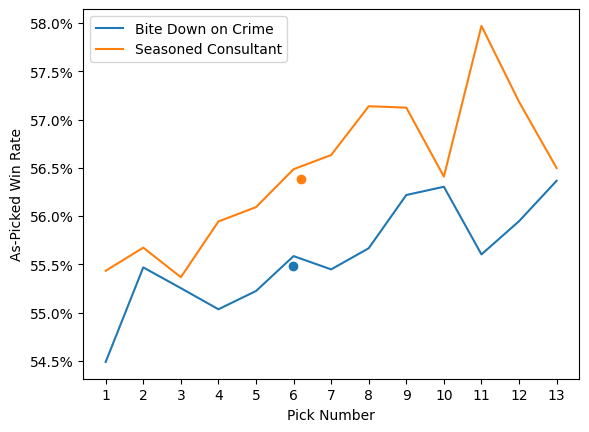

In [205]:
fig, ax = create_wr_vs_pick_plot()
for card_name in ['Bite Down on Crime', 'Seasoned Consultant']:
    add_card_plot(card_name, ax)
    
ax.legend()
None

In [203]:
include = numpy.logical_and(match_counts > MIN_SAMPLE_SIZE, numpy.roll(match_counts, -1) > MIN_SAMPLE_SIZE)
include_diff = include[:,0:12]

0.023978966204549534

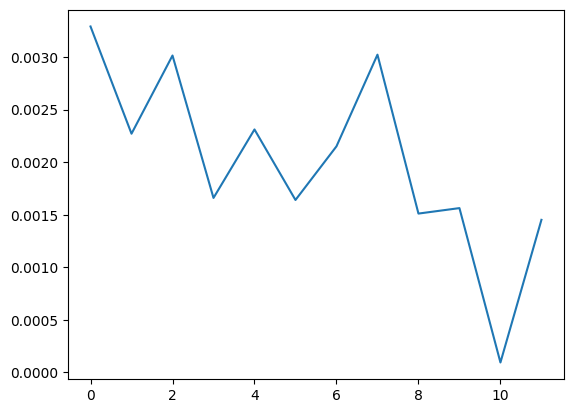

In [204]:
average_diff = numpy.average(match_wr_diff, axis=0, weights=include_diff)
fix, ax = pyplot.subplots()
ax.plot(numpy.arange(12), average_diff)
average_diff.sum()

In [ ]:
def sim_13_game(noise, trials):
    ata = numpy.zeros(13, 13);
    
    gpwr = ;
    p1 